In [4]:
import numpy as np
import random
import math
import time
import os
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 1. load data

In [5]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 1.1 Extract raw data

In [4]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheetname=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheetname=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...


D:\Program Files (x86)\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


Load datasets/CALCE/CS2_35\CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_18_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_24_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_28_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_4_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_18_10.xlsx ...
Load datasets/CALCE/C

## or 1.1 load the extracted data

**note: If the above loading fails, please load the .npy file.**

In [6]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('datasets/CALCE/CALCE.npy', allow_pickle=True)
Battery = Battery.item()

## 1.2 plot figures for capacity degradation

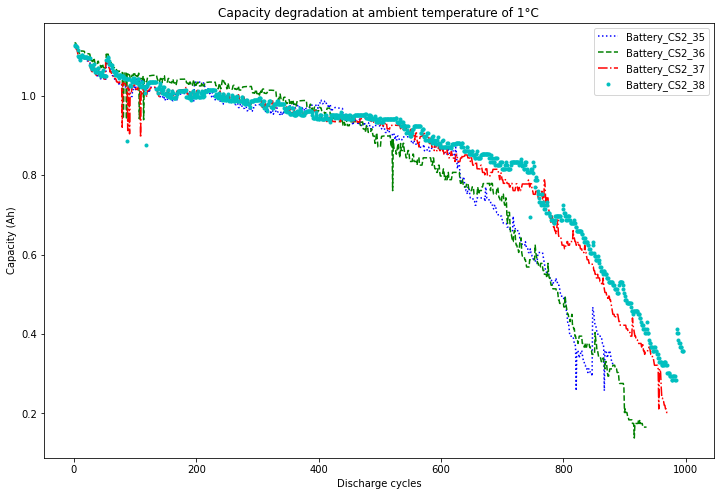

In [7]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

# 2. build model and train

## 2.1 build model

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_dim=8, noise_level=0.01):
        '''
        Args:
            input_size: the feature size of input data (required).
            hidden_dim: the hidden size of AutoEncoder (required).
            noise_level: the noise level added in Autoencoder (optional).
        '''
        super(Autoencoder, self).__init__()
        self.noise_level = noise_level
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_size)
        
    def encoder(self, x):
        x = self.fc1(x)
        h1 = F.relu(x)
        return h1
    
    def mask(self, x):
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x
    
    def decoder(self, x):
        h2 = self.fc2(x)
        return h2
    
    def forward(self, x):
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, feature_len, feature_size, dropout=0.0):
        '''
        Args:
            feature_len: the feature length of input data (required).
            feature_size: the feature size of input data (required).
            dropout: the dropout rate (optional).
        '''
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(feature_len, feature_size)
        position = torch.arange(0, feature_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, feature_size, 2).float() * (-math.log(10000.0) / feature_size))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe
        
        return x
    

class Net(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=32, feature_num=1, num_layers=1, nhead=1, dropout=0.0, noise_level=0.01):
        '''
        Args:
            feature_size: the feature size of input data (required).
            hidden_dim: the hidden size of Transformer block (required).
            feature_num: the number of features, such as capacity, voltage, and current; set 1 for only sigle feature (optional).
            num_layers: the number of layers of Transformer block (optional).
            nhead: the number of heads of multi-attention in Transformer block (optional).
            dropout: the dropout rate of Transformer block (optional).
            noise_level: the noise level added in Autoencoder (optional).
        '''
        super(Net, self).__init__()
        self.auto_hidden = int(feature_size / 2)
        input_size = self.auto_hidden 
        
        if feature_num == 1:
            # Transformer treated as an Encoder when modeling for a sigle feature like only capacity data
            self.pos = PositionalEncoding(feature_len=feature_num, feature_size=input_size)
            encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        elif feature_num > 1:
            # Transformer treated as a sequence model when modeling for multi-features like capacity, voltage, and current data
            self.pos = PositionalEncoding(feature_len=input_size, feature_size=feature_num)
            encoder_layers = nn.TransformerEncoderLayer(d_model=feature_num, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.cell = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.linear = nn.Linear(feature_num*self.auto_hidden, 1)
        self.autoencoder = Autoencoder(input_size=feature_size, hidden_dim=self.auto_hidden, noise_level=noise_level)
 
    def forward(self, x): 
        batch_size, feature_num, feature_size  = x.shape
        out, decode = self.autoencoder(x)
        if feature_num > 1:
            out = out.reshape(batch_size, -1, feature_num)
        out = self.pos(out)
        out = self.cell(out)              # sigle feature: (batch_size, feature_num, auto_hidden) or multi-features: (batch_size, auto_hidden, feature_num)
        out = out.reshape(batch_size, -1) # (batch_size, feature_num*auto_hidden)
        out = self.linear(out)            # out shape: (batch_size, 1)
        
        return out, decode

## 2.2 train for model

In [9]:
def train(lr=0.01, feature_size=8, feature_num=1, hidden_dim=32, num_layers=1, nhead=1, dropout=0.0, epochs=1000, 
          weight_decay=0.0, seed=0, alpha=0.0, noise_level=0.0, metric='re', device='cpu'):
    '''
        Args:
            lr: learning rate for training (required).
            feature_size: the feature size of input data (required).
            feature_num: the number of features, such as capacity, voltage, and current; set 1 for only sigle feature (optional).
            hidden_dim: the hidden size of Transformer block (required).
            num_layers: the number of layers of Transformer block (optional).
            nhead: the number of heads of multi-attention in Transformer block (optional).
            dropout: the dropout rate of Transformer block (optional).
            epochs: 
            weight_decay: 
            seed: (optional).
            alpha: (optional).
            noise_level: the noise level added in Autoencoder (optional).
            metric: (optional).
            device: (optional).
        '''
    score_list, fixed_result_list, moving_result_list = [], [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, feature_size)
        test_sequence = train_data + test_data
        # print('sample size: {}'.format(len(train_x)))

        model = Net(feature_size=feature_size, hidden_dim=hidden_dim, feature_num=K, num_layers=num_layers, 
                    nhead=nhead, dropout=dropout, noise_level=noise_level)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_fixed_slice, y_moving_slice = [0], [], []
        rmse, re = 1, 1
        score_, score = [1],[1]
        for epoch in range(epochs):
            x = np.reshape(train_x/Rated_Capacity,(-1, feature_num, feature_size)).astype(np.float32)
            y = np.reshape(train_y/Rated_Capacity,(-1,1)).astype(np.float32) 

            x, y = torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)
            x = x.repeat(1, K, 1)
            output, decode = model(x)
            output = output.reshape(-1, 1)
            loss = criterion(output, y) + alpha * criterion(decode, x)
            optimizer.zero_grad() 
            loss.backward()  
            optimizer.step()                   

            if (epoch + 1)%10 == 0:
                test_x = train_data.copy() 
                fixed_point_list, moving_point_list = [], []
                t = 0
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, feature_num, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device) 
                    x = x.repeat(1, K, 1)
                    pred, _ = model(x) 
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)      # The test values are added to the original sequence to continue to predict the next point
                    fixed_point_list.append(next_point) # Saves the predicted value of the last point in the output sequence
                    
                    x = np.reshape(np.array(test_sequence[t:t+feature_size])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device) 
                    x = x.repeat(1, K, 1)
                    pred, _ = model(x) 
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    moving_point_list.append(next_point) # Saves the predicted value of the last point in the output sequence
                    t += 1
                    
                y_fixed_slice.append(fixed_point_list)             # Save all the predicted values
                y_moving_slice.append(moving_point_list)

                loss_list.append(loss)
                rmse = evaluation(y_test=test_data, y_predict=y_fixed_slice[-1])
                re = relative_error(y_test=test_data, y_predict=y_fixed_slice[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))
                
            if metric == 're':
                score = [re]
            elif metric == 'rmse':
                score = [rmse]
            else:
                score = [re, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        fixed_result_list.append(train_data.copy() + y_fixed_slice[-1])
        moving_result_list.append(train_data.copy() + y_moving_slice[-1])
        
    return score_list, fixed_result_list, moving_result_list

## 2.3 setting and training for overall performance

In [10]:
Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
hidden_dim = 16
num_layers = 3
lr = 0.001  
weight_decay = 0.0
noise_level = 0.0
alpha = 0.1
metric = 're'
seed = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
K = 16

SCORE = []
for seed in tqdm(range(5)):
    print('seed:{}'.format(seed))
    score_list, _, _ = train(lr=lr, feature_size=feature_size, feature_num=feature_num, hidden_dim=hidden_dim, num_layers=num_layers, 
                             nhead=nhead, weight_decay=weight_decay, epochs=epochs, seed=seed, dropout=dropout, alpha=alpha, 
                             noise_level=noise_level, metric=metric, device=device)
    print(np.array(score_list))
    print(metric + 'for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))
    for s in score_list:
        SCORE.append(s)
    print('------------------------------------------------------------------')
print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

  0%|          | 0/5 [00:00<?, ?it/s]

seed:0
[[0.00174216]
 [0.01036269]
 [0.22153846]
 [0.01447178]]
refor this seed: 0.0620
------------------------------------------------------------------
seed:1
[[0.00522648]
 [0.00863558]
 [0.05692308]
 [0.00289436]]
refor this seed: 0.0184
------------------------------------------------------------------
seed:2
[[0.00174216]
 [0.01208981]
 [0.03538462]
 [0.13024602]]
refor this seed: 0.0449
------------------------------------------------------------------
seed:3
[[0.04181185]
 [0.07772021]
 [0.01230769]
 [0.06657019]]
refor this seed: 0.0496
------------------------------------------------------------------
seed:4
[[0.2369338 ]
 [0.        ]
 [0.03846154]
 [0.01013025]]
refor this seed: 0.0714
------------------------------------------------------------------
re mean: 0.0493


## 2.4 prediction for figures

In [11]:
Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
hidden_dim = 16
num_layers = 3
lr = 0.001  
weight_decay = 0.0
noise_level = 0.0
alpha = 0.1
metric = 're'
seed = 1

K = 16

SCORE = []
print('seed:{}'.format(seed))
score_list, fixed_result_list, moving_result_list = train(lr=lr, feature_size=feature_size, feature_num=feature_num, 
                                                          hidden_dim=hidden_dim, num_layers=num_layers,  nhead=nhead, 
                                                          weight_decay=weight_decay, epochs=epochs, seed=seed, dropout=dropout, 
                                                          alpha=alpha, noise_level=noise_level, metric=metric, device=device)
print(np.array(score_list))
for s in score_list:
    SCORE.append(s)
print('------------------------------------------------------------------')
print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

seed:1
[[0.00522648]
 [0.00863558]
 [0.05692308]
 [0.00289436]]
------------------------------------------------------------------
re mean: 0.0184


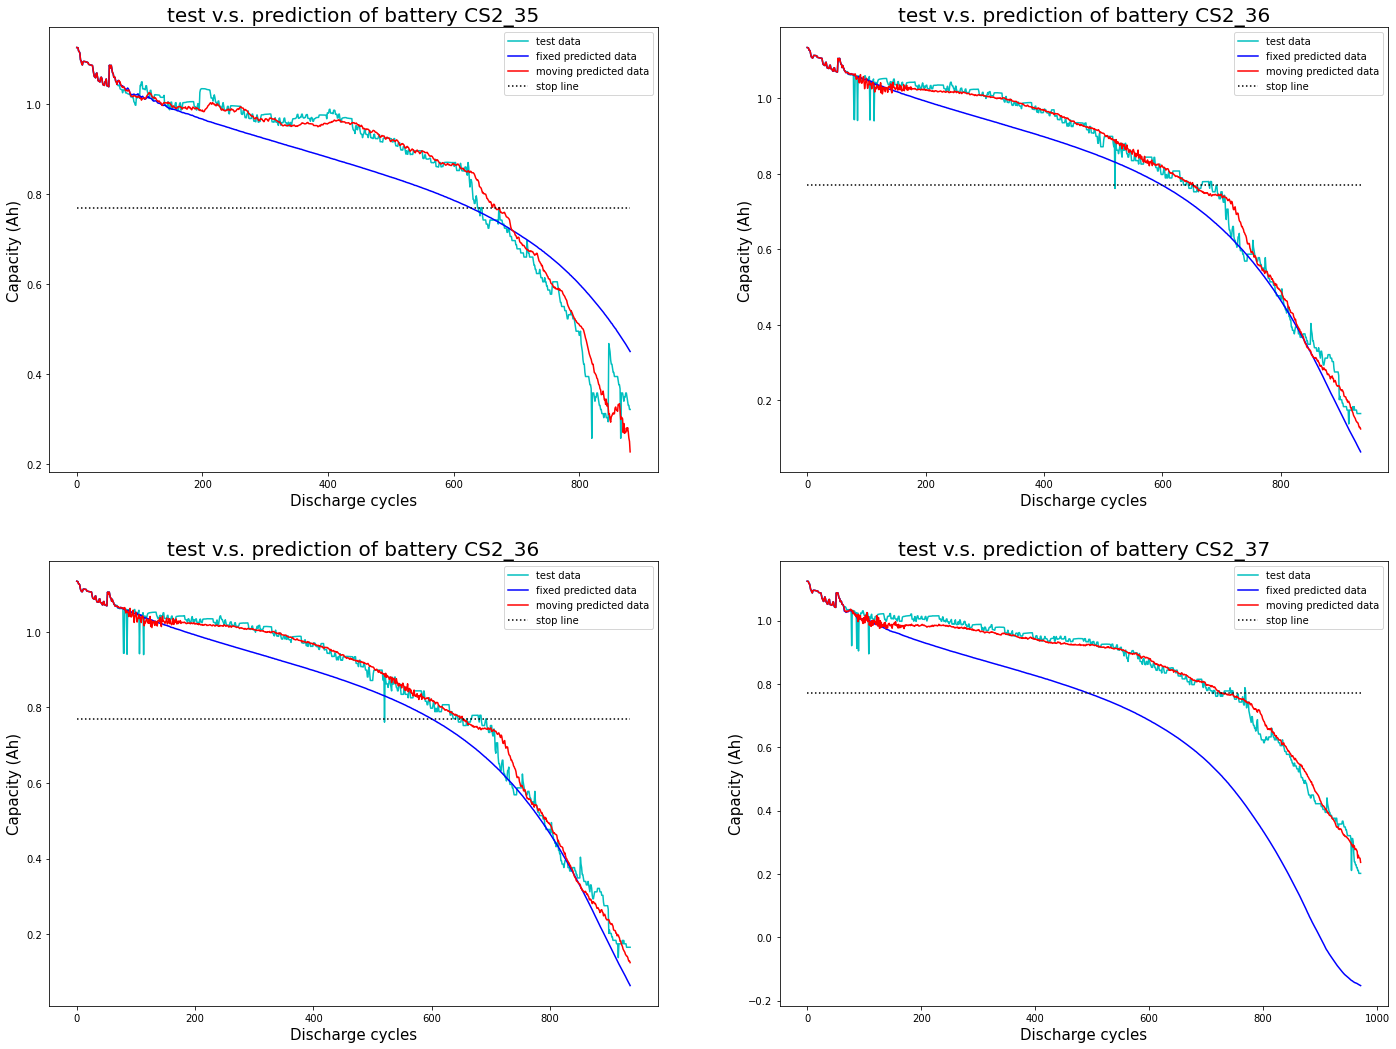

In [12]:
fig,ax = plt.subplots(2, 2, figsize=(24, 18))

for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = Battery[battery_name]['capacity']
        fixed_predict_data = fixed_result_list[t]
        moving_predict_data = moving_result_list[t]
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity*0.7] * len(test_data)
        ax[i][j].plot(x, test_data, 'c', label='test data')
        ax[i][j].plot(x, fixed_predict_data, 'b', label='fixed predicted data')
        ax[i][j].plot(x, moving_predict_data, 'r', label='moving predicted data')
        ax[i][j].plot(x, threshold, 'black', ls=':', label='stop line')
        ax[i][j].legend()
        ax[i][j].set_xlabel('Discharge cycles', fontsize=15)
        ax[i][j].set_ylabel('Capacity (Ah)', fontsize=15)
        ax[i][j].set_title('test v.s. prediction of battery ' + battery_name, fontsize=20)
plt.show()

# 3. use grid-search to determ parameters

In [16]:
Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
alpha = 0.1

weight_decay = 0.0
noise_level = 0.0
metric = 're'

states = {}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for K in tqdm([4, 8, 16, 32], position=0):
    for lr in tqdm([0.0001, 0.001, 0.01], position=1):
        for num_layers in tqdm([1, 2, 3], position=2):
            for hidden_dim in [8, 16, 32, 64]:
                show_str = 'K={}, lr={}, num_layers={}, hidden_dim={}'.format(K, lr, num_layers, hidden_dim)
                print(show_str)
                SCORE = []
                for seed in range(5):
                    print('seed:{}'.format(seed))
                    score_list, _, _ = train(lr=lr, feature_size=feature_size, feature_num=feature_num, hidden_dim=hidden_dim, 
                                             num_layers=num_layers, nhead=nhead, weight_decay=weight_decay, epochs=epochs, seed=seed, 
                                             dropout=dropout, alpha=alpha, noise_level=noise_level, metric=metric, device=device)
                    print(np.array(score_list))
                    print(metric + ': {:<6.4f}'.format(np.mean(np.array(score_list))))
                    print('------------------------------------------------------------------')
                    for s in score_list:
                        SCORE.append(s)

                print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
                states[show_str] = np.mean(np.array(SCORE))
                print('===================================================================')

min_key = min(states, key = states.get)
print('optimal parameters: {}, result: {}'.format(min_key, states[min_key]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

K=4, lr=0.0001, num_layers=1, hidden_dim=8
seed:0
[[0.34146341]
 [1.        ]
 [0.17692308]
 [0.48480463]]
re: 0.5008
------------------------------------------------------------------
seed:1
[[0.1097561 ]
 [0.12953368]
 [1.        ]
 [0.17221418]]
re: 0.3529
------------------------------------------------------------------
seed:2
[[0.01916376]
 [0.91364421]
 [0.15076923]
 [1.        ]]
re: 0.5209
------------------------------------------------------------------
seed:3
[[0.05923345]
 [1.        ]
 [0.56153846]
 [0.15050651]]
re: 0.4428
------------------------------------------------------------------
seed:4
[[1.        ]
 [0.09671848]
 [0.15692308]
 [0.16353111]]
re: 0.3543
------------------------------------------------------------------
re mean: 0.4343
K=4, lr=0.0001, num_layers=1, hidden_dim=16
seed:0
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:1
[[1.        ]
 [0.76165803]
 [0.11692308]
 [0.08104197]]
re: 0.4899
--

[[1.        ]
 [0.44559585]
 [0.71846154]
 [0.49927641]]
re: 0.6658
------------------------------------------------------------------
seed:1
[[0.20731707]
 [1.        ]
 [1.        ]
 [0.40955137]]
re: 0.6542
------------------------------------------------------------------
seed:2
[[1.        ]
 [0.09499136]
 [1.        ]
 [0.92185239]]
re: 0.7542
------------------------------------------------------------------
seed:3
[[1.        ]
 [1.        ]
 [1.        ]
 [0.08827786]]
re: 0.7721
------------------------------------------------------------------
seed:4
[[1.        ]
 [1.        ]
 [0.58769231]
 [0.1910275 ]]
re: 0.6947
------------------------------------------------------------------
re mean: 0.7082
K=4, lr=0.0001, num_layers=3, hidden_dim=64
seed:0
[[0.22299652]
 [0.07772021]
 [0.37846154]
 [1.        ]]
re: 0.4198
------------------------------------------------------------------
seed:1
[[0.12020906]
 [1.        ]
 [0.52307692]
 [1.        ]]
re: 0.6608
--------------------

  0%|          | 0/3 [00:00<?, ?it/s]

K=4, lr=0.001, num_layers=1, hidden_dim=8
seed:0
[[0.01393728]
 [0.04663212]
 [0.29384615]
 [0.14327062]]
re: 0.1244
------------------------------------------------------------------
seed:1
[[0.03484321]
 [0.26943005]
 [0.14153846]
 [0.06512301]]
re: 0.1277
------------------------------------------------------------------
seed:2
[[0.09407666]
 [1.        ]
 [0.22769231]
 [0.00434153]]
re: 0.3315
------------------------------------------------------------------
seed:3
[[0.01219512]
 [0.15716753]
 [0.15076923]
 [0.03183792]]
re: 0.0880
------------------------------------------------------------------
seed:4
[[0.0174216 ]
 [0.00345423]
 [0.03846154]
 [0.04196816]]
re: 0.0253
------------------------------------------------------------------
re mean: 0.1394
K=4, lr=0.001, num_layers=1, hidden_dim=16
seed:0
[[0.10627178]
 [0.03108808]
 [0.08461538]
 [0.01736614]]
re: 0.0598
------------------------------------------------------------------
seed:1
[[0.01045296]
 [0.2193437 ]
 [0.08615385

[[0.31358885]
 [0.07081174]
 [0.55384615]
 [0.02170767]]
re: 0.2400
------------------------------------------------------------------
seed:1
[[0.00522648]
 [0.41968912]
 [0.01846154]
 [0.22286541]]
re: 0.1666
------------------------------------------------------------------
seed:2
[[0.06794425]
 [0.06735751]
 [0.14461538]
 [0.09696093]]
re: 0.0942
------------------------------------------------------------------
seed:3
[[0.03658537]
 [0.16580311]
 [0.08923077]
 [0.1910275 ]]
re: 0.1207
------------------------------------------------------------------
seed:4
[[0.21080139]
 [0.32642487]
 [0.22153846]
 [0.25470333]]
re: 0.2534
------------------------------------------------------------------
re mean: 0.1750
K=4, lr=0.001, num_layers=3, hidden_dim=64
seed:0
[[0.07839721]
 [0.15544041]
 [0.11846154]
 [0.05065123]]
re: 0.1007
------------------------------------------------------------------
seed:1
[[0.17421603]
 [0.09671848]
 [0.24615385]
 [0.07091172]]
re: 0.1470
---------------------

  0%|          | 0/3 [00:00<?, ?it/s]

K=4, lr=0.01, num_layers=1, hidden_dim=8
seed:0
[[0.6445993 ]
 [0.17271157]
 [0.61076923]
 [0.11432706]]
re: 0.3856
------------------------------------------------------------------
seed:1
[[0.28919861]
 [0.00863558]
 [0.48615385]
 [0.02315485]]
re: 0.2018
------------------------------------------------------------------
seed:2
[[0.06794425]
 [0.05872193]
 [0.03230769]
 [0.        ]]
re: 0.0397
------------------------------------------------------------------
seed:3
[[0.01219512]
 [0.18307427]
 [0.35076923]
 [0.17366136]]
re: 0.1799
------------------------------------------------------------------
seed:4
[[0.30487805]
 [0.49740933]
 [0.06153846]
 [0.34442836]]
re: 0.3021
------------------------------------------------------------------
re mean: 0.2218
K=4, lr=0.01, num_layers=1, hidden_dim=16
seed:0
[[0.33797909]
 [0.47668394]
 [0.07384615]
 [0.18379161]]
re: 0.2681
------------------------------------------------------------------
seed:1
[[0.03135889]
 [0.3626943 ]
 [0.10615385]


[[0.06097561]
 [0.00690846]
 [0.02153846]
 [0.58610709]]
re: 0.1689
------------------------------------------------------------------
seed:1
[[0.        ]
 [0.02417962]
 [0.15692308]
 [0.07525326]]
re: 0.0641
------------------------------------------------------------------
seed:2
[[0.04703833]
 [0.6148532 ]
 [0.43230769]
 [0.47612156]]
re: 0.3926
------------------------------------------------------------------
seed:3
[[0.06794425]
 [0.39378238]
 [0.02769231]
 [0.25759768]]
re: 0.1868
------------------------------------------------------------------
seed:4
[[0.33623693]
 [0.69948187]
 [0.67230769]
 [0.14037627]]
re: 0.4621
------------------------------------------------------------------
re mean: 0.2549
K=4, lr=0.01, num_layers=3, hidden_dim=64
seed:0
[[0.30836237]
 [0.20552677]
 [0.66      ]
 [0.32561505]]
re: 0.3749
------------------------------------------------------------------
seed:1
[[0.80139373]
 [0.09499136]
 [0.51692308]
 [0.0984081 ]]
re: 0.3779
----------------------

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

K=8, lr=0.0001, num_layers=1, hidden_dim=8
seed:0
[[0.02961672]
 [1.        ]
 [0.19692308]
 [0.27062229]]
re: 0.3743
------------------------------------------------------------------
seed:1
[[0.38501742]
 [0.00345423]
 [1.        ]
 [1.        ]]
re: 0.5971
------------------------------------------------------------------
seed:2
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:3
[[0.36062718]
 [1.        ]
 [0.22      ]
 [0.05499276]]
re: 0.4089
------------------------------------------------------------------
seed:4
[[1.        ]
 [1.        ]
 [0.32461538]
 [1.        ]]
re: 0.8312
------------------------------------------------------------------
re mean: 0.6423
K=8, lr=0.0001, num_layers=1, hidden_dim=16
seed:0
[[0.61498258]
 [1.        ]
 [1.        ]
 [0.0463097 ]]
re: 0.6653
------------------------------------------------------------------
seed:1
[[0.02787456]
 [0.3626943 ]
 [0.4       ]
 [0.14616498]]
re: 0.2342
--

[[0.27874564]
 [0.05181347]
 [0.19538462]
 [1.        ]]
re: 0.3815
------------------------------------------------------------------
seed:1
[[1.        ]
 [0.03108808]
 [0.13230769]
 [0.10274964]]
re: 0.3165
------------------------------------------------------------------
seed:2
[[0.31184669]
 [0.        ]
 [0.44615385]
 [1.        ]]
re: 0.4395
------------------------------------------------------------------
seed:3
[[0.03135889]
 [0.56476684]
 [0.13692308]
 [0.31259045]]
re: 0.2614
------------------------------------------------------------------
seed:4
[[1.        ]
 [1.        ]
 [0.05538462]
 [0.27496382]]
re: 0.5826
------------------------------------------------------------------
re mean: 0.3963
K=8, lr=0.0001, num_layers=3, hidden_dim=64
seed:0
[[0.44076655]
 [0.04145078]
 [0.09230769]
 [0.17510854]]
re: 0.1874
------------------------------------------------------------------
seed:1
[[0.10801394]
 [0.11053541]
 [0.27846154]
 [0.24457308]]
re: 0.1854
--------------------

  0%|          | 0/3 [00:00<?, ?it/s]

K=8, lr=0.001, num_layers=1, hidden_dim=8
seed:0
[[0.00522648]
 [0.2642487 ]
 [0.14461538]
 [0.20115774]]
re: 0.1538
------------------------------------------------------------------
seed:1
[[0.02961672]
 [0.02936097]
 [0.02923077]
 [0.14616498]]
re: 0.0586
------------------------------------------------------------------
seed:2
[[0.30662021]
 [0.43868739]
 [0.05692308]
 [0.01013025]]
re: 0.2031
------------------------------------------------------------------
seed:3
[[0.00348432]
 [0.16925734]
 [0.03538462]
 [0.3024602 ]]
re: 0.1276
------------------------------------------------------------------
seed:4
[[0.18292683]
 [0.11053541]
 [0.20769231]
 [0.17366136]]
re: 0.1687
------------------------------------------------------------------
re mean: 0.1424
K=8, lr=0.001, num_layers=1, hidden_dim=16
seed:0
[[0.02787456]
 [0.35405872]
 [0.02      ]
 [0.05209841]]
re: 0.1135
------------------------------------------------------------------
seed:1
[[0.09756098]
 [0.00863558]
 [0.25692308

[[0.01567944]
 [0.01208981]
 [0.08461538]
 [0.14761216]]
re: 0.0650
------------------------------------------------------------------
seed:1
[[0.12891986]
 [0.07081174]
 [0.42769231]
 [0.14327062]]
re: 0.1927
------------------------------------------------------------------
seed:2
[[0.00348432]
 [0.01727116]
 [0.06307692]
 [0.08972504]]
re: 0.0434
------------------------------------------------------------------
seed:3
[[0.0087108 ]
 [0.30051813]
 [0.00153846]
 [0.0723589 ]]
re: 0.0958
------------------------------------------------------------------
seed:4
[[0.02439024]
 [0.18134715]
 [0.05538462]
 [0.1577424 ]]
re: 0.1047
------------------------------------------------------------------
re mean: 0.1003
K=8, lr=0.001, num_layers=3, hidden_dim=64
seed:0
[[0.32229965]
 [0.01899827]
 [0.17538462]
 [0.07525326]]
re: 0.1480
------------------------------------------------------------------
seed:1
[[0.0174216 ]
 [0.09153713]
 [0.23076923]
 [0.22720695]]
re: 0.1417
---------------------

  0%|          | 0/3 [00:00<?, ?it/s]

K=8, lr=0.01, num_layers=1, hidden_dim=8
seed:0
[[0.19686411]
 [0.15544041]
 [0.11692308]
 [0.29377713]]
re: 0.1908
------------------------------------------------------------------
seed:1
[[0.75958188]
 [0.19343696]
 [0.00923077]
 [0.03328509]]
re: 0.2489
------------------------------------------------------------------
seed:2
[[0.12543554]
 [0.35405872]
 [0.01846154]
 [0.1316932 ]]
re: 0.1574
------------------------------------------------------------------
seed:3
[[0.41811847]
 [0.35924007]
 [0.53230769]
 [0.        ]]
re: 0.3274
------------------------------------------------------------------
seed:4
[[0.14808362]
 [0.06908463]
 [0.15076923]
 [0.0853835 ]]
re: 0.1133
------------------------------------------------------------------
re mean: 0.2076
K=8, lr=0.01, num_layers=1, hidden_dim=16
seed:0
[[0.05400697]
 [0.32469775]
 [0.02461538]
 [0.15050651]]
re: 0.1385
------------------------------------------------------------------
seed:1
[[0.16376307]
 [0.05181347]
 [0.58307692]


[[0.21602787]
 [0.01208981]
 [0.17230769]
 [0.74384949]]
re: 0.2861
------------------------------------------------------------------
seed:1
[[0.16898955]
 [0.01208981]
 [0.14923077]
 [0.00434153]]
re: 0.0837
------------------------------------------------------------------
seed:2
[[0.02787456]
 [0.03108808]
 [0.06461538]
 [0.41823444]]
re: 0.1355
------------------------------------------------------------------
seed:3
[[0.11498258]
 [0.02936097]
 [0.81692308]
 [0.65267728]]
re: 0.4035
------------------------------------------------------------------
seed:4
[[0.10627178]
 [0.34196891]
 [0.01692308]
 [0.10709117]]
re: 0.1431
------------------------------------------------------------------
re mean: 0.2103
K=8, lr=0.01, num_layers=3, hidden_dim=64
seed:0
[[0.11324042]
 [0.53367876]
 [0.32153846]
 [0.17221418]]
re: 0.2852
------------------------------------------------------------------
seed:1
[[0.1010453 ]
 [0.31778929]
 [0.70153846]
 [0.33285094]]
re: 0.3633
----------------------

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

K=16, lr=0.0001, num_layers=1, hidden_dim=8
seed:0
[[0.29616725]
 [1.        ]
 [0.01384615]
 [0.0853835 ]]
re: 0.3488
------------------------------------------------------------------
seed:1
[[0.05923345]
 [0.10017271]
 [0.16      ]
 [0.07380608]]
re: 0.0983
------------------------------------------------------------------
seed:2
[[0.11149826]
 [1.        ]
 [0.19846154]
 [1.        ]]
re: 0.5775
------------------------------------------------------------------
seed:3
[[0.08362369]
 [1.        ]
 [1.        ]
 [0.10853835]]
re: 0.5480
------------------------------------------------------------------
seed:4
[[1.        ]
 [0.07599309]
 [0.24      ]
 [0.07091172]]
re: 0.3467
------------------------------------------------------------------
re mean: 0.3839
K=16, lr=0.0001, num_layers=1, hidden_dim=16
seed:0
[[1.        ]
 [0.26252159]
 [0.57538462]
 [0.17945007]]
re: 0.5043
------------------------------------------------------------------
seed:1
[[0.07491289]
 [0.08981002]
 [0.1153

[[0.02090592]
 [1.        ]
 [0.59384615]
 [0.03473227]]
re: 0.4124
------------------------------------------------------------------
seed:1
[[1.        ]
 [1.        ]
 [1.        ]
 [0.24891462]]
re: 0.8122
------------------------------------------------------------------
seed:2
[[1.        ]
 [0.0656304 ]
 [0.09692308]
 [0.19971056]]
re: 0.3406
------------------------------------------------------------------
seed:3
[[0.04355401]
 [0.16234888]
 [0.18769231]
 [0.24167873]]
re: 0.1588
------------------------------------------------------------------
seed:4
[[0.41637631]
 [0.06217617]
 [0.16615385]
 [0.51230101]]
re: 0.2893
------------------------------------------------------------------
re mean: 0.4026
K=16, lr=0.0001, num_layers=3, hidden_dim=64
seed:0
[[0.03484321]
 [0.00518135]
 [0.18461538]
 [0.35745297]]
re: 0.1455
------------------------------------------------------------------
seed:1
[[0.37456446]
 [0.22797927]
 [0.38      ]
 [0.08827786]]
re: 0.2677
-------------------

  0%|          | 0/3 [00:00<?, ?it/s]

K=16, lr=0.001, num_layers=1, hidden_dim=8
seed:0
[[0.08536585]
 [0.12607945]
 [0.02307692]
 [0.22431259]]
re: 0.1147
------------------------------------------------------------------
seed:1
[[0.06968641]
 [0.02417962]
 [0.14      ]
 [0.21418234]]
re: 0.1120
------------------------------------------------------------------
seed:2
[[0.05226481]
 [0.11917098]
 [0.15230769]
 [0.24457308]]
re: 0.1421
------------------------------------------------------------------
seed:3
[[0.03135889]
 [0.1865285 ]
 [0.27076923]
 [0.17655572]]
re: 0.1663
------------------------------------------------------------------
seed:4
[[0.3902439 ]
 [0.02590674]
 [0.08769231]
 [0.01447178]]
re: 0.1296
------------------------------------------------------------------
re mean: 0.1329
K=16, lr=0.001, num_layers=1, hidden_dim=16
seed:0
[[0.39198606]
 [0.25043178]
 [0.21538462]
 [0.01881331]]
re: 0.2192
------------------------------------------------------------------
seed:1
[[0.04181185]
 [0.02936097]
 [0.066153

[[0.04181185]
 [0.07599309]
 [0.01846154]
 [0.19392185]]
re: 0.0825
------------------------------------------------------------------
seed:1
[[0.05226481]
 [0.17789292]
 [0.02923077]
 [0.03183792]]
re: 0.0728
------------------------------------------------------------------
seed:2
[[0.21428571]
 [0.03799655]
 [0.01846154]
 [0.18958032]]
re: 0.1151
------------------------------------------------------------------
seed:3
[[0.01219512]
 [0.07081174]
 [0.05846154]
 [0.16931983]]
re: 0.0777
------------------------------------------------------------------
seed:4
[[0.05574913]
 [0.13989637]
 [0.03692308]
 [0.18379161]]
re: 0.1041
------------------------------------------------------------------
re mean: 0.0904
K=16, lr=0.001, num_layers=3, hidden_dim=64
seed:0
[[0.00348432]
 [0.39032815]
 [0.19846154]
 [0.01881331]]
re: 0.1528
------------------------------------------------------------------
seed:1
[[0.03832753]
 [0.04490501]
 [0.02307692]
 [0.15484805]]
re: 0.0653
--------------------

  0%|          | 0/3 [00:00<?, ?it/s]

K=16, lr=0.01, num_layers=1, hidden_dim=8
seed:0
[[1.        ]
 [0.25734024]
 [0.04461538]
 [0.01013025]]
re: 0.3280
------------------------------------------------------------------
seed:1
[[0.01916376]
 [0.21588946]
 [0.16      ]
 [1.        ]]
re: 0.3488
------------------------------------------------------------------
seed:2
[[1.        ]
 [1.        ]
 [1.        ]
 [0.20839363]]
re: 0.8021
------------------------------------------------------------------
seed:3
[[0.18989547]
 [1.        ]
 [0.20307692]
 [0.11287988]]
re: 0.3765
------------------------------------------------------------------
seed:4
[[0.00174216]
 [1.        ]
 [0.00153846]
 [0.1316932 ]]
re: 0.2837
------------------------------------------------------------------
re mean: 0.4278
K=16, lr=0.01, num_layers=1, hidden_dim=16
seed:0
[[1.        ]
 [0.12780656]
 [0.54615385]
 [0.11287988]]
re: 0.4467
------------------------------------------------------------------
seed:1
[[0.24216028]
 [0.0880829 ]
 [1.        

[[0.15679443]
 [1.        ]
 [0.14461538]
 [0.02749638]]
re: 0.3322
------------------------------------------------------------------
seed:1
[[0.17770035]
 [0.02590674]
 [0.12      ]
 [0.56005789]]
re: 0.2209
------------------------------------------------------------------
seed:2
[[0.48954704]
 [1.        ]
 [0.09384615]
 [0.80463097]]
re: 0.5970
------------------------------------------------------------------
seed:3
[[0.38850174]
 [1.        ]
 [0.12615385]
 [0.26193922]]
re: 0.4441
------------------------------------------------------------------
seed:4
[[0.71428571]
 [0.37305699]
 [0.16461538]
 [0.15195369]]
re: 0.3510
------------------------------------------------------------------
re mean: 0.3891
K=16, lr=0.01, num_layers=3, hidden_dim=64
seed:0
[[0.02787456]
 [0.27633851]
 [0.00923077]
 [0.26917511]]
re: 0.1457
------------------------------------------------------------------
seed:1
[[0.33275261]
 [0.38687392]
 [0.07384615]
 [1.        ]]
re: 0.4484
---------------------

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

K=32, lr=0.0001, num_layers=1, hidden_dim=8
seed:0
[[0.04703833]
 [1.        ]
 [0.25230769]
 [1.        ]]
re: 0.5748
------------------------------------------------------------------
seed:1
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:2
[[1.        ]
 [0.34542314]
 [1.        ]
 [0.02460203]]
re: 0.5925
------------------------------------------------------------------
seed:3
[[0.06445993]
 [1.        ]
 [1.        ]
 [1.        ]]
re: 0.7661
------------------------------------------------------------------
seed:4
[[1.        ]
 [0.1208981 ]
 [1.        ]
 [0.03473227]]
re: 0.5389
------------------------------------------------------------------
re mean: 0.6945
K=32, lr=0.0001, num_layers=1, hidden_dim=16
seed:0
[[1.        ]
 [1.        ]
 [1.        ]
 [0.14616498]]
re: 0.7865
------------------------------------------------------------------
seed:1
[[1.       ]
 [1.       ]
 [1.       ]
 [0.0260492]]
re: 0.7565
----

[[0.41289199]
 [1.        ]
 [0.15692308]
 [1.        ]]
re: 0.6425
------------------------------------------------------------------
seed:1
[[0.08362369]
 [0.09671848]
 [1.        ]
 [0.21997106]]
re: 0.3501
------------------------------------------------------------------
seed:2
[[1.        ]
 [0.08635579]
 [0.81230769]
 [0.32995658]]
re: 0.5572
------------------------------------------------------------------
seed:3
[[0.52090592]
 [0.32124352]
 [0.23230769]
 [0.16931983]]
re: 0.3109
------------------------------------------------------------------
seed:4
[[0.18989547]
 [0.4507772 ]
 [1.        ]
 [0.03617945]]
re: 0.4192
------------------------------------------------------------------
re mean: 0.4560
K=32, lr=0.0001, num_layers=3, hidden_dim=64
seed:0
[[0.05923345]
 [0.19861831]
 [0.51230769]
 [0.17800289]]
re: 0.2370
------------------------------------------------------------------
seed:1
[[0.0261324 ]
 [0.10189983]
 [0.10307692]
 [0.00868307]]
re: 0.0599
-------------------

  0%|          | 0/3 [00:00<?, ?it/s]

K=32, lr=0.001, num_layers=1, hidden_dim=8
seed:0
[[0.3466899 ]
 [0.29015544]
 [0.04461538]
 [0.10419682]]
re: 0.1964
------------------------------------------------------------------
seed:1
[[0.14285714]
 [0.00172712]
 [0.08769231]
 [0.06946454]]
re: 0.0754
------------------------------------------------------------------
seed:2
[[1.        ]
 [0.02417962]
 [0.01076923]
 [0.10274964]]
re: 0.2844
------------------------------------------------------------------
seed:3
[[0.39721254]
 [0.19861831]
 [0.00307692]
 [0.05065123]]
re: 0.1624
------------------------------------------------------------------
seed:4
[[0.07839721]
 [0.01899827]
 [0.22307692]
 [0.00434153]]
re: 0.0812
------------------------------------------------------------------
re mean: 0.1600
K=32, lr=0.001, num_layers=1, hidden_dim=16
seed:0
[[0.01219512]
 [0.00863558]
 [0.16461538]
 [0.1577424 ]]
re: 0.0858
------------------------------------------------------------------
seed:1
[[0.00348432]
 [0.34715026]
 [0.018461

[[0.08362369]
 [0.27288428]
 [0.18615385]
 [0.02170767]]
re: 0.1411
------------------------------------------------------------------
seed:1
[[0.03658537]
 [0.00345423]
 [0.01692308]
 [0.19971056]]
re: 0.0642
------------------------------------------------------------------
seed:2
[[0.01045296]
 [0.07944732]
 [0.22769231]
 [0.07814761]]
re: 0.0989
------------------------------------------------------------------
seed:3
[[0.11324042]
 [0.32124352]
 [0.08307692]
 [0.10709117]]
re: 0.1562
------------------------------------------------------------------
seed:4
[[0.00696864]
 [0.39205527]
 [0.02769231]
 [0.04196816]]
re: 0.1172
------------------------------------------------------------------
re mean: 0.1155
K=32, lr=0.001, num_layers=3, hidden_dim=64
seed:0
[[0.1184669 ]
 [0.37823834]
 [0.22153846]
 [0.21562952]]
re: 0.2335
------------------------------------------------------------------
seed:1
[[0.0087108 ]
 [0.36960276]
 [0.05692308]
 [0.19392185]]
re: 0.1573
--------------------

  0%|          | 0/3 [00:00<?, ?it/s]

K=32, lr=0.01, num_layers=1, hidden_dim=8
seed:0
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:1
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:2
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:3
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:4
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
re mean: 1.0000
K=32, lr=0.01, num_layers=1, hidden_dim=16
seed:0
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:1
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:2
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:3
[[1.]
 [1.]


[[1.        ]
 [1.        ]
 [1.        ]
 [0.02170767]]
re: 0.7554
------------------------------------------------------------------
seed:4
[[1.        ]
 [1.        ]
 [0.46307692]
 [0.1186686 ]]
re: 0.6454
------------------------------------------------------------------
re mean: 0.8601
K=32, lr=0.01, num_layers=3, hidden_dim=64
seed:0
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:1
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:2
[[1.        ]
 [1.        ]
 [0.30923077]
 [1.        ]]
re: 0.8273
------------------------------------------------------------------
seed:3
[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:4
[[1.        ]
 [1.        ]
 [1.        ]
 [0.46599132]]
re: 0.8665
------------------------------------------------------------------
re mean: 0.9388
optimal parameters: K=16, lr=0.001